# How to crawling? - Naver Real Estate Map

In [11]:
#import custom module
import nre.con as nc
import nre.util as nu
from IPython.display import clear_output 
from matplotlib import pyplot as plt
import seaborn as sns
import cv2

sns.set(rc={'figure.figsize':(11.7,8.27)})

nu.IS_LOGGING = False

## 위치을 이용하여 구역 특정

In [3]:
#loc = nc.NLocation(35.18213, 128.1366) # 진주 충무공동
loc = nc.NLocation(37.49911, 127.065463) # 강남 대치동

#https://new.land.naver.com/complexes?ms=37.49911,127.065463,16&a=APT:OPST&b=B1:A1&e=RETAIL&s=EE

cur_region = nc.NRegion('', loc, '0000000000')

# 검색해서 지역 찾기
while True:
    regions = nu.get_region_list(cur_region.no)
    if len(regions) == 0: break
    for i, region in enumerate(regions): 
        print(i, region)
        
    idx = int(input("원하는 도시 인덱스(exit -1) : "))
    clear_output()
    if idx == -1: break
    cur_region = regions[idx]

In [4]:
sector = nu.get_sector(cur_region.loc)
smap = sector.map

print(sector)

서울시 강남구 개포동 1168010300 loc(37.482968 | 127.063400)


## 매물 조건 생성

In [5]:
addon = nc.NAddon(
    #direction=nc.NAddon.DIR_EACH, #전 방향 탐색의 경우 사용 - 아래 로직을 바꾸세요
    tradeType=[nc.NAddon.TRADE_DEAL, nc.NAddon.TRADE_LEASE], #목표 거래 - 매매, 전세
    estateType=[nc.NAddon.ESTATE_APT, nc.NAddon.ESTATE_OPST] #목표 매물 - 아파트, 오피스텔
)

## 조건과 구역을 이용하여 매물 탐색

In [6]:
things = [] # 매물 기록
removed = 0
for dirr in nc.NAddon.DIR_EACH: # 모든 방향 (남향 등등)
    addon.dir = dirr # 방향 조건 선택
    values = []
    for v in nu.get_things(sector, addon):
        if smap.contain(v.loc) is False: # 구역 포함되어있는지
            removed += 1 
            continue 
        v.dir = dirr # 매물 방향 정의
        values.append(v)
    things.extend(values)
print('올바른 매물 수', len(things), '제거됨', removed)

올바른 매물 수 53 제거됨 82


## 구역 주변 편의 시설 탐색

In [7]:
neighbors = [] # 편의시설 기록
for nType in nc.NNeighbor.EACH: # 모든 편의시설
    values = []
    res = nu.get_neighborhood(sector.loc, nType)
    
    for r in res:
        if smap.contain(r.loc):
            values.append(r)
    neighbors.extend(values)
    print(nType, len(values))
print('Total', len(neighbors))

BUS 55
METRO 2
INFANT 21
PRESCHOOL 3
SCHOOLPOI 30
HOSPITAL 0
PARKING 8
MART 3
CONVENIENCE 16
WASHING 14
BANK 10
OFFICE 7
Total 169


# 편의시설과 매물 간의 거리 탐색

In [8]:
# 500 == 걸어서 5~10분 이내, 버스로 1분
# 1000 == 버스로 1~2분 

standard = nu.get_distance_standard() # 거리 기준

for (key, value) in standard.items():
    print(key, value, 'm')

BUS 500 m
METRO 500 m
INFANT 750 m
PRESCHOOL 750 m
SCHOOLPOI 2000 m
HOSPITAL 5000 m
PARKING 500 m
MART 500 m
CONVENIENCE 250 m
WASHING 500 m
BANK 1000 m
OFFICE 2000 m


In [9]:
for thing in things: # 매물
    around = nc.NNeighborAround()
    for nei in neighbors: # 편의시설
        d = nu.distance_between(thing.loc, nei.loc)
        if d <= standard[nei.type]: # meter
            around.increase(nei.type)
    thing.neiAround = around

## 시각화

Dusts 222
APT	(0, 255, 0)
ABYG	(0, 255, 0)
OPST	(255, 0, 0)
OBYG	(255, 0, 0)
JGB	(0, 0, 255)
JGC	(0, 0, 255)
BUS	(0, 255, 255)
METRO	(0, 255, 255)
INFANT	(255, 255, 0)
PRESCHOOL	(255, 255, 0)
SCHOOLPOI	(255, 0, 255)
HOSPITAL	(0, 0, 0)
PARKING	(0, 0, 0)
MART	(0, 0, 0)
CONVENIENCE	(0, 0, 0)
WASHING	(0, 0, 0)
BANK	(0, 0, 0)
OFFICE	(0, 0, 0)


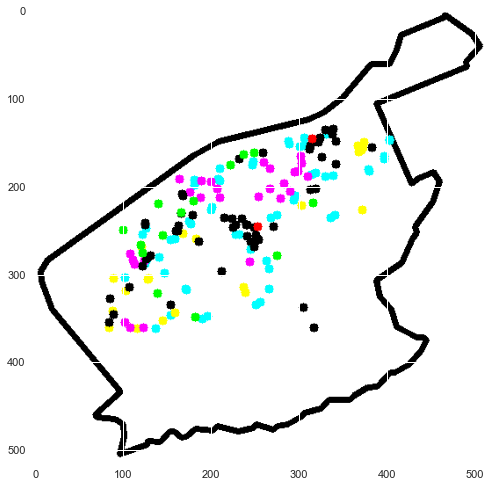

In [12]:
dm = smap.get_dimension()

dusts = nu.neighbors_to_dusts(neighbors, dm)
dusts.extend(nu.things_to_dusts(things, dm))

color_tag = nc.NDimension.get_default_tag_color()

print('Dusts', len(dusts))
for key,value in color_tag.items():
    print(key, value, sep='\t')

plt.imshow(cv2.rotate(dm.get_img(dusts, color_tag), cv2.ROTATE_90_COUNTERCLOCKWISE)) 

## Dataframe

In [13]:
import pandas as pd

def old_classifier(x): #old 구분
    value = abs(int(x[0:4]) - 2022)
    if value <= 5:
        return 'New'
    elif value <= 10:
        return 'Common'
    return 'Old'

In [14]:
thing_df = pd.DataFrame(data=[t.get_list() for t in things], columns=nc.NThing.HEADER)
nei_df = pd.DataFrame(data=[t.neiAround.get_list() for t in things], columns=nc.NNeighborAround.HEADER)

total_df = pd.concat([thing_df, nei_df], axis=1)
total_df['Old'] = total_df['Build'].apply(old_classifier)
total_df['sector'] = sector.name

total_df

,Name,Type,Build,Dir,minArea,maxArea,representativeArea,floorAreaRatio,minDeal,maxDeal,...,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE,Old,sector
0,세영팔래스,APT,200201,EE,73.77,103.37,103.0,237,175000.0,200000.0,...,20,0,20,1,10,14,35,6,Old,대치동
1,삼환SOGOOD(주상복합),APT,200611,EE,107.38,133.52,133.0,359,220000.0,220000.0,...,20,0,16,2,7,10,32,6,Old,대치동
2,대치대우아이빌명문가(주상복합),APT,200402,EE,41.88,53.58,41.0,637,31000.0,38000.0,...,20,0,23,3,14,10,18,6,Old,대치동
3,대치대우아이빌명문가,OPST,200402,EE,57.05,59.01,57.0,637,31000.0,32000.0,...,20,0,23,3,14,10,18,6,Old,대치동
4,동양,APT,199901,EE,112.14,112.14,112.0,223,NaN,NaN,...,20,0,16,2,6,12,20,6,Old,대치동
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,동양,APT,199901,WN,112.14,112.14,112.0,223,NaN,NaN,...,20,0,16,2,6,12,20,6,Old,대치동
138,대치클래시아,OPST,201512,WN,42.36,61.63,61.0,0,51000.0,65000.0,...,20,0,10,4,7,8,26,6,Common,대치동
139,바실리체,OPST,202203,WN,67.34,153.29,67.0,799,86000.0,370000.0,...,20,0,22,2,6,8,19,6,New,대치동
140,청원,APT,200502,WN,114.52,114.72,114.0,260,NaN,NaN,...,20,0,19,3,10,12,33,6,Old,대치동


In [15]:
total_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142 entries, 0 to 141
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                142 non-null    object 
 1   Type                142 non-null    object 
 2   Build               142 non-null    object 
 3   Dir                 142 non-null    object 
 4   minArea             142 non-null    object 
 5   maxArea             142 non-null    object 
 6   representativeArea  142 non-null    float64
 7   floorAreaRatio      142 non-null    int64  
 8   minDeal             127 non-null    float64
 9   maxDeal             127 non-null    float64
 10  medianDeal          127 non-null    float64
 11  minLease            120 non-null    float64
 12  maxLease            120 non-null    float64
 13  medianLease         103 non-null    float64
 14  minDealUnit         127 non-null    float64
 15  maxDealUnit         127 non-null    float64
 16  medianDe

In [16]:
total_df.describe()

,representativeArea,floorAreaRatio,minDeal,maxDeal,medianDeal,minLease,maxLease,medianLease,minDealUnit,maxDealUnit,...,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,142.000000,142.000000,127.000000,127.000000,127.000000,120.000000,120.000000,103.000000,127.000000,127.000000,...,142.000000,142.000000,142.0,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,99.070423,354.549296,177212.598425,246393.700787,192353.149606,107583.333333,153129.166667,123330.097087,5623.937008,6533.645669,...,13.647887,1.633803,20.0,0.0,18.359155,2.514085,8.105634,9.774648,23.950704,6.0
std,43.509785,251.068344,120745.214498,168972.015974,132532.701228,70281.339890,101186.957671,79925.165777,2471.007284,2804.177656,...,4.755284,0.699330,0.0,0.0,5.567563,1.397749,4.406165,3.138402,6.551842,0.0
min,32.000000,0.000000,26000.000000,29000.000000,27750.000000,19000.000000,19000.000000,23000.000000,1569.000000,1846.000000,...,8.000000,0.000000,20.0,0.0,4.000000,0.000000,0.000000,4.000000,14.000000,6.0
25%,67.000000,243.000000,71500.000000,107500.000000,78650.000000,65000.000000,70000.000000,67500.000000,3474.500000,4011.000000,...,10.000000,1.000000,20.0,0.0,15.250000,2.000000,6.000000,8.000000,19.000000,6.0
50%,94.000000,267.500000,185000.000000,220000.000000,185000.000000,100000.000000,117500.000000,110000.000000,5797.000000,6494.000000,...,12.000000,2.000000,20.0,0.0,19.000000,2.000000,7.000000,10.000000,22.000000,6.0
75%,124.000000,434.000000,252500.000000,370000.000000,260000.000000,140750.000000,220000.000000,162500.000000,7189.000000,8531.000000,...,16.000000,2.000000,20.0,0.0,22.000000,3.000000,12.000000,12.000000,30.000000,6.0
max,225.000000,1096.000000,505000.000000,560000.000000,510000.000000,450000.000000,450000.000000,450000.000000,10093.000000,11702.000000,...,26.000000,3.000000,20.0,0.0,34.000000,6.000000,16.000000,19.000000,37.000000,6.0


In [17]:
nei_df.describe() 

,BUS,METRO,INFANT,PRESCHOOL,SCHOOLPOI,HOSPITAL,PARKING,MART,CONVENIENCE,WASHING,BANK,OFFICE
count,142.000000,142.000000,142.000000,142.000000,142.0,142.0,142.000000,142.000000,142.000000,142.000000,142.000000,142.0
mean,9.676056,0.204225,13.647887,1.633803,20.0,0.0,18.359155,2.514085,8.105634,9.774648,23.950704,6.0
std,4.271876,0.454118,4.755284,0.699330,0.0,0.0,5.567563,1.397749,4.406165,3.138402,6.551842,0.0
min,4.000000,0.000000,8.000000,0.000000,20.0,0.0,4.000000,0.000000,0.000000,4.000000,14.000000,6.0
25%,6.000000,0.000000,10.000000,1.000000,20.0,0.0,15.250000,2.000000,6.000000,8.000000,19.000000,6.0
50%,8.000000,0.000000,12.000000,2.000000,20.0,0.0,19.000000,2.000000,7.000000,10.000000,22.000000,6.0
75%,14.000000,0.000000,16.000000,2.000000,20.0,0.0,22.000000,3.000000,12.000000,12.000000,30.000000,6.0
max,18.000000,2.000000,26.000000,3.000000,20.0,0.0,34.000000,6.000000,16.000000,19.000000,37.000000,6.0


## 시각화 라벨

In [26]:
target_lbl = 'minLease'

## 방향에 따른 가격

<AxesSubplot:xlabel='Dir', ylabel='minLease'>

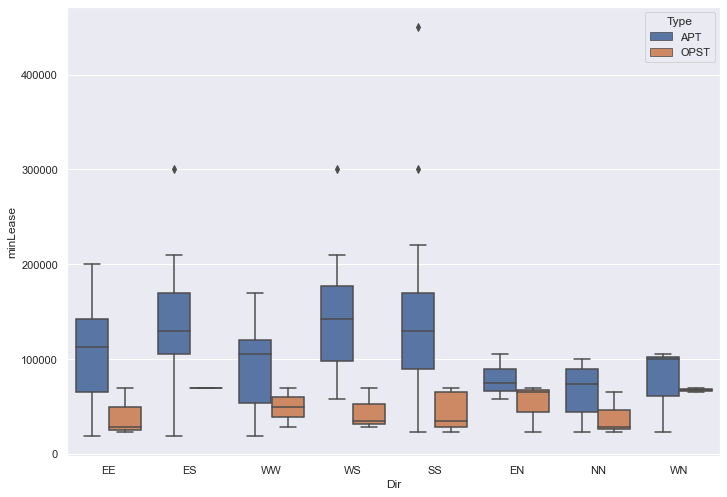

In [27]:
sns.boxplot(x='Dir', y = target_lbl, hue='Type', data=total_df)

## 오피스텔과 아파트 차이

<AxesSubplot:xlabel='Type', ylabel='minLease'>

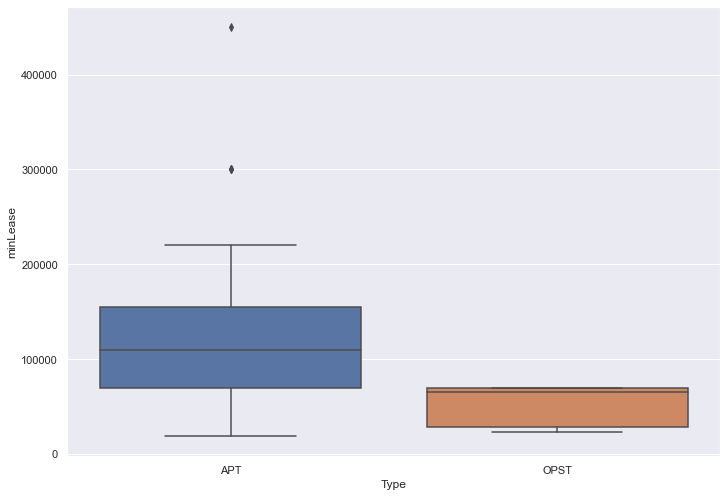

In [28]:
sns.boxplot(x='Type', y = target_lbl, data=total_df)

## 연식에 따른 차이

<AxesSubplot:xlabel='Old', ylabel='minLease'>

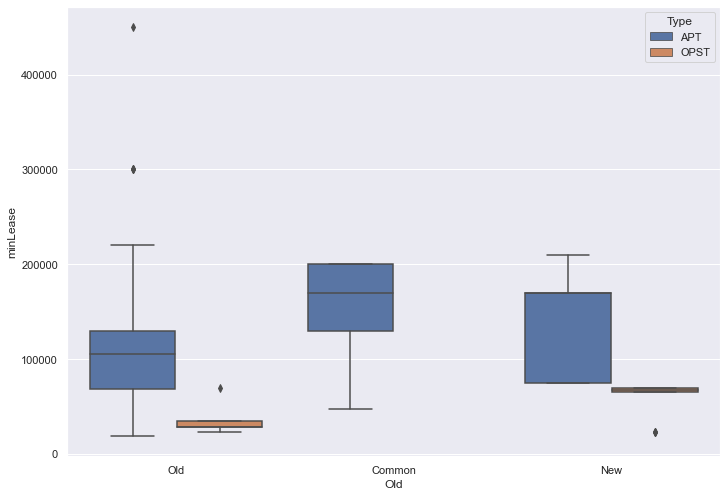

In [29]:
sns.boxplot(x='Old', y = target_lbl, hue='Type', data=total_df)

## 저장

In [21]:
total_df.to_csv('./csv/%s - %s house_price.csv' % (sector.name, sector.city), sep=',', na_rep='NaN', index=False)